In [1]:
# python -u train.py ETTh1 forecast_multivar --archive forecast_csv --repr-dims 320 --gpu 0 --seed 42 --eval
# python -u train.py BME classification --archive UCR --repr-dims 320 --gpu 0 --seed 42 --eval
import numpy as np
import datautils
from ts2vec import TS2Vec
from sklearn.linear_model import Ridge
from matplotlib import pyplot as plt

In [2]:
def generate_pred_samples(features, data, pred_len, drop=0):
    n = data.shape[1]
    features = features[:, :-pred_len]
    labels = np.stack([ data[:, i:1+n+i-pred_len] for i in range(pred_len)], axis=2)[:, 1:]
    features = features[:, drop:]
    labels = labels[:, drop:]
    return features.reshape(-1, features.shape[-1]), \
            labels.reshape(-1, labels.shape[2]*labels.shape[3])

def cal_metrics(pred, target):
    return {
        'MSE': ((pred - target) ** 2).mean(),
        'MAE': np.abs(pred - target).mean()
    }

data, _, _, _, _, _, _ = datautils.load_forecast_csv('ETTh1')
data = data[:,:1000,]

model = TS2Vec(
    input_dims=data.shape[-1],
    device='cpu',
    output_dims=320
)

model.load('datasets/model.pkl')
all_repr = model.encode(
    data,
    casual=True,
    sliding_length=1,
    sliding_padding=200,
    batch_size=256
)

In [3]:
train_data = data[:, :800, 13:]
valid_data = data[:, 800:, 13:]
train_repr = all_repr[:, :800]
valid_repr = all_repr[:, 800:]

In [4]:
n = valid_data.shape[1]
pred_len = 24
feat, label = generate_pred_samples(train_repr, train_data, pred_len)
clf = Ridge(alpha=0.1).fit(feat, label)

In [5]:
test_feat, test_label = generate_pred_samples(valid_repr, valid_data, pred_len)
pred = clf.predict(test_feat)
cal_metrics(pred, test_label)

{'MSE': 0.2722134568908309, 'MAE': 0.4184495388824482}

{'MSE': 0.03668809880258489, 'MAE': 0.1393430842475272}


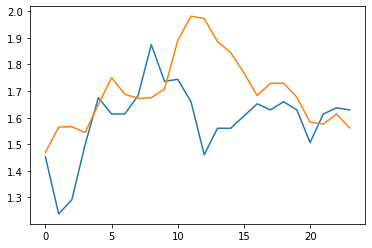

In [9]:
print(cal_metrics(pred[0], valid_data.reshape(-1)[1:pred_len+1]))
plt.plot(valid_data.reshape(-1)[1:pred_len+1])
plt.plot(pred[0])
plt.show()